# Bush/Rubio/Cruz Donor Movement Analysis

The code below looks for donors who stopped given to a certain 2016 presidential candidate's official committee, and then began giving to another candidate's committee. A few notes and caveats:

- The analysis focuses on __inidividual contributors__ to the __official committees__ of each campaign. It does not examine organizational contributors or contributions to Super PACs, leadership committees, or other candidate-support groups.


- The Federal Election Commission does not assign unique IDs to contributors. As an approximation, this code considers two contributions to have come from __the same donor if they share all three of the following attributes__:
    - Last name
    - First name
    - 5-digit ZIP code


- Because of the lack of unique IDs, and the possibility that donors change name-spellings or ZIP codes between contributions, this method may not capture all donor movement. Additionally, if two donors with the same first and last name live in the same ZIP code, they will be mistakenly labeled as the same person.

In [1]:
import pandas as pd
import io
import glob
import seaborn as sb
%matplotlib inline

## Define committee names and IDs

In [2]:
BUSH = "Jeb 2016, Inc."
RUBIO = "Marco Rubio for President"
CRUZ = "Cruz for President"

In [3]:
committees = {
    "C00579458": BUSH,
    "C00458844": RUBIO,
    "C00574624": CRUZ,
}

## Load contributions from two most recent quarterly filings

For the official committees supporting Walker, Bush, Rubio, Cruz, and Fiorina, we load the two most recent quarterly filings — the July and October filings. The one exception is Walker; his committee officially began in July, and so only has an October quarterly filing.

In [4]:
filings = glob.glob("../data/fec-filings/*.fec")

In [5]:
def profile_filing(path):
    with open(path) as f:
        header = f.readline()
        f3 = pd.read_csv(io.StringIO(f.readline()), header=None).iloc[0]
    return "|".join(map(str, [committees[f3[1]], f3[15], f3[16], path]))

In [6]:
for p in sorted(map(profile_filing, filings)):
    print(p)

Cruz for President|20150401|20150630|../data/fec-filings/1024046.fec
Cruz for President|20150701|20150930|../data/fec-filings/1032443.fec
Cruz for President|20151001|20151231|../data/fec-filings/1046977.fec
Jeb 2016, Inc.|20150401|20150630|../data/fec-filings/1024106.fec
Jeb 2016, Inc.|20150701|20150930|../data/fec-filings/1029571.fec
Jeb 2016, Inc.|20151001|20151231|../data/fec-filings/1047278.fec
Marco Rubio for President|20150401|20150630|../data/fec-filings/1029436.fec
Marco Rubio for President|20150701|20150930|../data/fec-filings/1031526.fec
Marco Rubio for President|20151001|20151231|../data/fec-filings/1047126.fec


In [7]:
with open("../data/contrib-fields.txt") as f:
    contrib_fields = f.read().strip().split("\n")

In [8]:
def get_indiv_contributions(path):
    with open(path) as f:
        sa17a = (line for line in f if line[:7] == '"SA17A"')
        contributions = pd.read_csv(io.StringIO("\n".join(sa17a)),
            header=None,
            names=contrib_fields,
            parse_dates=["contribution_date"],
            dtype={ "contributor_zip": str },
            low_memory=False)
    return contributions[
        contributions["entity_type"] == "IND"
    ].copy()

In [9]:
contributions = pd.concat([ get_indiv_contributions(f) for f in filings ])

In [10]:
contributions["committee"] = contributions["filer_committee_id_number"].apply(committees.get)

In [11]:
contributions["zip_5"] = contributions["contributor_zip"].fillna("").apply(lambda x: x[:5])

In [12]:
print("{0:,d} total contributions".format(len(contributions)))

232,071 total contributions


### Total *itemitzed* individual contributions. 

This number does not reflect the total amount raised by the commmittees; it does not, for example, include donations from organizations; small, "unitemized" donations; or contributions from other committees.

In [13]:
contributions.groupby("committee")["contribution_amount"].sum().sort_values(ascending=False)

committee
Jeb 2016, Inc.               30164050.32
Cruz for President           27715519.78
Marco Rubio for President    23295886.56
Name: contribution_amount, dtype: float64

## Add donor "index" as a substitute for unique ID

In [14]:
def make_donor_index(donor):
    is_null = lambda x: pd.isnull(x) or (len(x) == 0)
    if is_null(donor["zip_5"]) \
    or is_null(donor["contributor_first_name"]) \
    or is_null(donor["contributor_last_name"]):
        return None
    fmt = "{contributor_last_name}|{contributor_first_name}|{zip_5}"
    return fmt.format(**donor).upper()

In [15]:
contributions["donor_index"] = contributions.apply(make_donor_index, axis=1)

## Find first and last date of contribution to each committee

In [16]:
grp = contributions.sort_values("contribution_date").groupby([ "donor_index", "committee" ])

donor_firsts = grp["contribution_date"].first().unstack()
donor_lasts = grp["contribution_date"].last().unstack()

In [17]:
def find_movement(from_committee, to_committee):
    donors = donor_firsts[[ from_committee, to_committee ]]\
        .join(donor_lasts[[ from_committee, to_committee ]], lsuffix="_first", rsuffix="_last")\
        .dropna()
    donors = donors[list(sorted(donors.columns))]
    moves = donors[
        donors[to_committee + "_first"] > donors[from_committee + "_last"]
    ]
    return moves

In [18]:
def plot_movement(from_committee, to_committee, color, title):
    moves = find_movement(from_committee, to_committee)
    monthly = moves.set_index(to_committee + "_first").resample("MS", how="size")
    ax = monthly.plot(kind="bar", width=0.85, color=color,
        figsize=(10, 6), fontsize=12)
    ax.set_title(title, fontsize=18, fontweight="bold")
    ax.set_ylabel("# Donors", fontsize=14, fontweight="bold")
    ax.set_xlabel("Month", fontsize=14, fontweight="bold")
    ax.set_ylim(0, ax.get_ylim()[1] * 1.05)
    ax.set_xticklabels([ x.strftime("%Y-%m") for x in monthly.index ], rotation=0)
    ax.figure.set_facecolor("#FFFFFF")
    return ax

## Approximately how many former Bush donors gave to Rubio for the first time in December?

In [19]:
bush_to_rubio = find_movement(BUSH, RUBIO)

In [20]:
bush_to_rubio_dec = bush_to_rubio[
    bush_to_rubio[RUBIO + "_first"] >= "2015-12-01"
]
len(bush_to_rubio_dec)

119

## How much did those donors contribute in December?

In [21]:
contributions[
    (contributions["committee"] == RUBIO) &
    (contributions["donor_index"].isin(bush_to_rubio_dec.index))
]["contribution_amount"].sum()

249500.0

## Charts

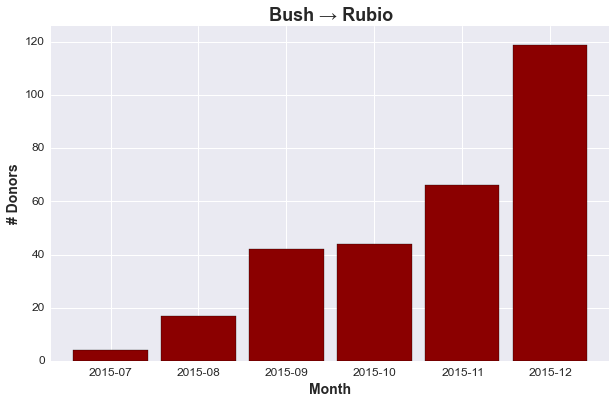

In [22]:
ax = plot_movement(BUSH, RUBIO, "darkred", "Bush → Rubio")

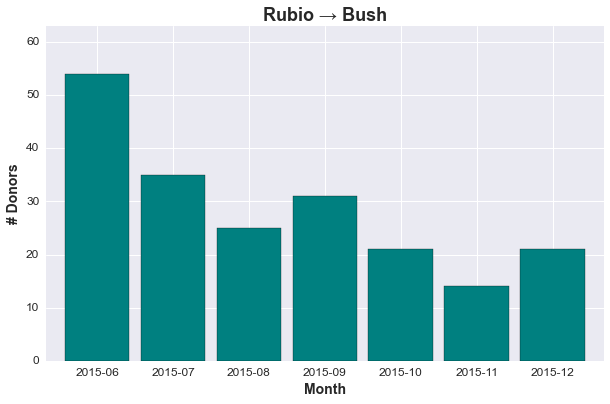

In [23]:
ax = plot_movement(RUBIO, BUSH, "teal", "Rubio → Bush")

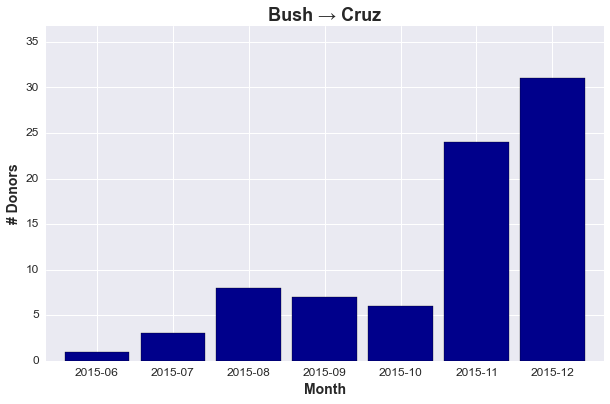

In [24]:
ax = plot_movement(BUSH, CRUZ, "darkblue", "Bush → Cruz")

---

---

---